<a href="https://colab.research.google.com/github/christinajoslin/cnn-dog-cat-breed-classifier/blob/main/Dog_and_Cat_Breed_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries

# pandas for data manipulation and analysis
import pandas as pd

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# TensorFlow for deep learning tasks
import tensorflow as tf

# MobileNetV2 (pre-trained model) for transfer learning
from tensorflow.keras.applications import MobileNetV2

# load_model for loading saved Keras models
from tensorflow.keras.models import load_model

# Model and layers for building custom neural networks
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# zipfile for handling compressed datasets
import zipfile

# os for file and directory operations
import os

# NumPy for numerical computations
import numpy as np

# matplotlib.pyplot for plotting
import matplotlib.pyplot as plt

# classification_report for generating evaluation metrics (precision, recall, F1-score, support)
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive  # Import the drive module from google.colab

# Attempt to unmount Google Drive to prevent potential mounting errors
try:
    drive.flush_and_unmount()  # Flush any pending changes and unmount the drive
    print('Drive unmounted')  # Print a message indicating successful unmounting
except ValueError:
    pass  # Ignore the ValueError if the drive is not already mounted

# Mount Google Drive to access files
drive.mount('/content/drive', force_remount=True)  # Mount the drive to the specified path, forcing a remount

Drive not mounted, so nothing to flush and unmount.
Drive unmounted
Mounted at /content/drive


In [3]:
extract_to = '/content/drive/MyDrive/Colab Notebooks/Dogs and Cats Breed Classifier/' #adjust according to your file path
zip_path = '/content/drive/MyDrive/Colab Notebooks/archive.zip' #adjust according to your file path

In [4]:
# Code to unzip 'archive.zip' and extract its contents into directories for training, test, and validation datasets

# Ensure the target directory for extraction exists; create it if it doesn’t
# os.makedirs(extract_to, exist_ok=True)

# Open the ZIP file specified by `zip_path` in read mode
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all files into the specified directory (`extract_to`)
    # zip_ref.extractall(extract_to)

# Print a confirmation message once extraction is complete
# print(f"Dataset successfully extracted to: {extract_to}")


In [4]:
# Identify the directories for training, test, and validation datasets
# These directories are assumed to be subfolders within the extraction directory (`extract_to`)

# Define the path to the training directory
train_dir = os.path.join(extract_to, 'train')  # Combines the base path (`extract_to`) with the 'train' subdirectory

# Define the path to the test directory
test_dir = os.path.join(extract_to, 'test')  # Combines the base path (`extract_to`) with the 'test' subdirectory

# Define the path to the validation directory
val_dir = os.path.join(extract_to, 'valid')  # Combines the base path (`extract_to`) with the 'valid' subdirectory

# Print the identified directories to verify the paths are correct
print(f"Training Directory: {train_dir}")  # Displays the path to the training data
print(f"Test Directory: {test_dir}")       # Displays the path to the test data
print(f"Validation Directory: {val_dir}") # Displays the path to the validation data


Training Directory: /content/drive/MyDrive/Colab Notebooks/Dogs and Cats Breed Classifier/train
Test Directory: /content/drive/MyDrive/Colab Notebooks/Dogs and Cats Breed Classifier/test
Validation Directory: /content/drive/MyDrive/Colab Notebooks/Dogs and Cats Breed Classifier/valid


In [5]:
# Load training, test, and validation datasets using TensorFlow's image_dataset_from_directory function

# Load the training dataset from the specified directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,  # Path to the directory containing training images, organized by class subdirectories
    label_mode="int",  # Labels are returned as integers (class indices), compatible with SparseCategoricalCrossentropy
    batch_size=64,  # Number of images to process in each batch during training
    image_size=(224, 224)  # Resize all images to 224x224 pixels to match the input size of many pre-trained models
)

# Load the test dataset from the specified directory
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,  # Path to the directory containing test images, organized by class subdirectories
    label_mode="int",  # Labels are returned as integers for compatibility with the evaluation process
    batch_size=64,  # Number of images to process in each batch during testing
    image_size=(224, 224)  # Resize all images to 224x224 pixels
)

# Load the validation dataset from the specified directory
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,  # Path to the directory containing validation images, organized by class subdirectories
    label_mode="int",  # Labels are returned as integers to support validation metrics
    batch_size=64,  # Number of images to process in each batch during validation
    image_size=(224, 224)  # Resize all images to 224x224 pixels
)


Found 26752 files belonging to 104 classes.
Found 892 files belonging to 104 classes.
Found 1339 files belonging to 104 classes.


In [6]:
# Calculate the total number of breeds
class_names = train_dataset.class_names  # Get the list of class names from the training dataset
num_of_breeds = len(class_names)  # Calculate the total number of breeds by counting the class names
print(f"Total Number of Breeds: {num_of_breeds}")  # Print the total number of breeds

# Define preprocessing function
def preprocess(image, label):
  """
  This function preprocesses an image and its label.

  Args:
    image: The input image tensor.
    label: The corresponding label tensor.

  Returns:
    A tuple containing the preprocessed image and label.
  """
  image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize the image to the range [0, 1]
  return image, label

# Apply preprocessing to the datasets
train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)


Total Number of Breeds: 104


In [13]:
# Load the pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    include_top=False,  # Exclude the classification layer (top) of the pre-trained model
    input_shape=(224, 224, 3)  # Specify the input shape for the model (224x224 pixels, 3 color channels)
)

# Get the output of the base model
x = base_model.output

# Apply Global Average Pooling to reduce spatial dimensions
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with ReLU activation and L2 regularization
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05))(x)

# Add a Dropout layer for regularization
x = Dropout(0.5)(x)

# Add the final output layer with softmax activation and L2 regularization
output = Dense(num_of_breeds, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

# Create the final model by specifying inputs and outputs
model = Model(inputs=base_model.input, outputs=output)

In [16]:
# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor for early stopping (validation accuracy)
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define the optimizer with a reduced learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Use the Adam optimizer with a learning rate of 1e-4

In [17]:
# Compile the model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification with integer labels
    metrics=['accuracy']  # Evaluation metric
)

In [18]:
# Train the model
# This step might take a considerable amount of time (e.g., a few hours) depending on the dataset size and model complexity.
history = model.fit(
    train_dataset,  # Training data
    epochs=20,  # Maximum number of training epochs
    validation_data=(val_dataset),  # Validation data for monitoring performance
    batch_size=64,  # Number of samples processed before updating model weights
    callbacks=[early_stopping]  # Early stopping to prevent overfitting
)

Epoch 1/20
418/418 [==============================] - 720s 2s/step - loss: 16.0722 - accuracy: 0.4181 - val_loss: 9.0203 - val_accuracy: 0.6064
Epoch 2/20
418/418 [==============================] - 696s 2s/step - loss: 5.8341 - accuracy: 0.7411 - val_loss: 4.0280 - val_accuracy: 0.7453
Epoch 3/20
418/418 [==============================] - 692s 2s/step - loss: 2.9424 - accuracy: 0.8267 - val_loss: 2.5790 - val_accuracy: 0.7760
Epoch 4/20
418/418 [==============================] - 688s 2s/step - loss: 1.9898 - accuracy: 0.8794 - val_loss: 2.1147 - val_accuracy: 0.7991
Epoch 5/20
418/418 [==============================] - 679s 2s/step - loss: 1.6055 - accuracy: 0.9133 - val_loss: 1.8889 - val_accuracy: 0.8170
Epoch 6/20
418/418 [==============================] - 680s 2s/step - loss: 1.3780 - accuracy: 0.9446 - val_loss: 1.7617 - val_accuracy: 0.8118
Epoch 7/20
418/418 [==============================] - 686s 2s/step - loss: 1.2204 - accuracy: 0.9619 - val_loss: 1.5960 - val_accuracy: 0.819

In [19]:
# Save the entire model for future use
# This is crucial to avoid retraining, especially after a long training process (e.g., several hours).
model.save('/content/drive/MyDrive/Colab Notebooks/Dogs and Cats Breed Classifier/model.keras')

In [ ]:
#Reload the saved model using the code below
#model = load_model('/content/drive/MyDrive/Colab Notebooks/Dogs and Cats Breed Classifier/model.keras')


In [20]:
# Save the model weights for further training or fine-tuning if preferred.
# This allows you to load the weights into a new model with the same architecture and resume training
# without starting from scratch, which can be beneficial for transfer learning or incremental training.
model.save_weights('/content/drive/MyDrive/Colab Notebooks/Dogs and Cats Breed Classifier/model_weights.keras')

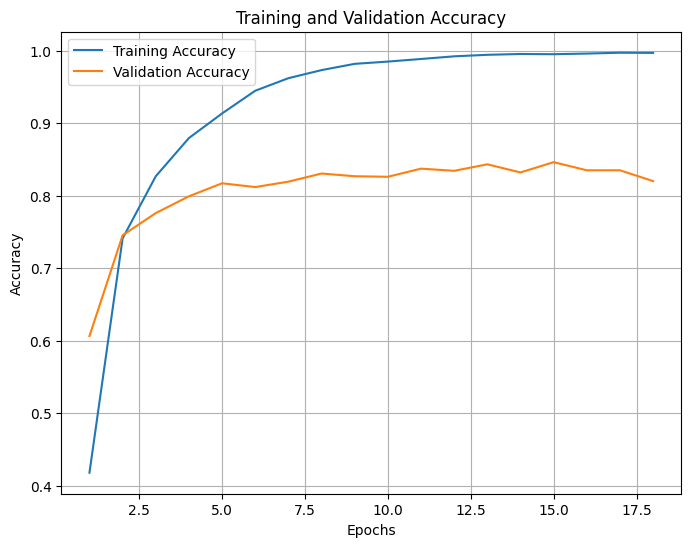

In [21]:
# Extract training and validation accuracy values from the training history.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Generate a range of epochs for plotting.
epochs = range(1, len(training_accuracy) + 1)

# Create a figure and plot the training and validation accuracy curves.
plt.figure(figsize=(8, 6))  # Set the figure size
plt.plot(epochs, training_accuracy, label='Training Accuracy')  # Plot training accuracy
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')  # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Set the plot title
plt.xlabel('Epochs')  # Set the x-axis label
plt.ylabel('Accuracy')  # Set the y-axis label
plt.legend()  # Display the legend


In [22]:
# Evaluate the model's performance on the training and test sets.

# Evaluate on the test set
model_results_test = model.evaluate(test_dataset)  # Get loss and accuracy on the test set
print(f"Test Set Accuracy from MobileNetV2: {model_results_test[1]}")  # Print test accuracy

# Evaluate on the training set
model_results_train = model.evaluate(train_dataset)  # Get loss and accuracy on the training set
print(f"Training Set Accuracy from MobileNetV2: {model_results_train[1]}\n")  # Print training accuracy

14/14 [==============================] - 9s 407ms/step - loss: 1.2381 - accuracy: 0.8352
Test Set Accuracy from MobileNetV2: 0.8352017998695374
418/418 [==============================] - 177s 421ms/step - loss: 0.6297 - accuracy: 0.9990
Training Set Accuracy from MobileNetV2 0.9989533424377441



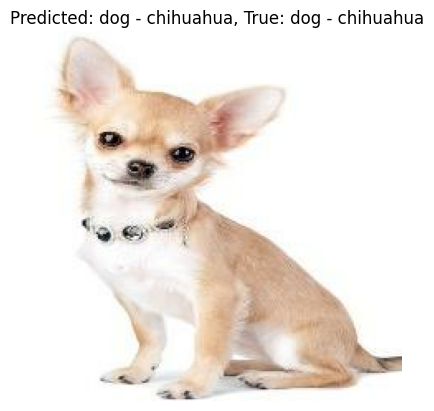

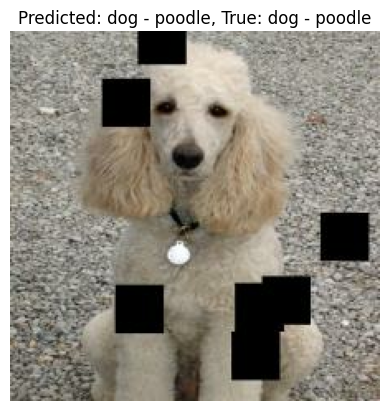

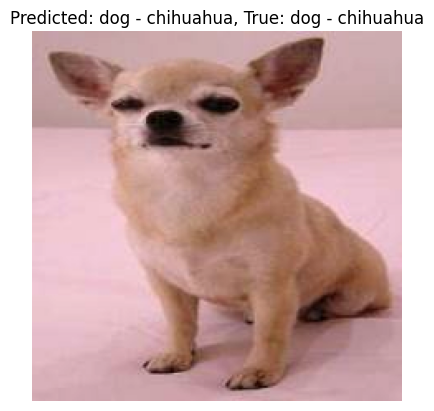

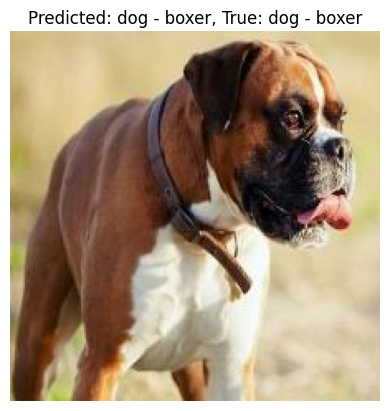

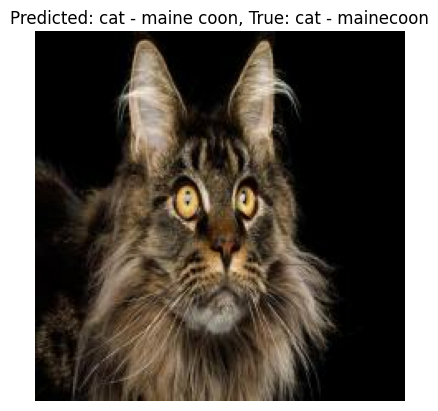

In [57]:
# Initialize lists to store predicted labels and true labels for all images in the test dataset.
all_predicted_labels = []  # Stores the predicted class indices for each image
all_true_labels = []  # Stores the actual class indices for each image

# Initialize a counter to keep track of the number of images displayed.
displayed_count = 0

# Iterate through the entire test dataset to obtain predictions and true labels for all images.
for images, labels in test_dataset:
    # Get model predictions for the current batch of images.
    predictions = model.predict(images, verbose=0)  # verbose=0 suppresses prediction progress output

    # Extract the predicted class indices (labels) from the predictions.
    predicted_indices = np.argmax(predictions, axis=1)  # Get the index of the highest probability class

    # Append the predicted and true labels to the respective lists.
    all_predicted_labels.extend(predicted_indices)
    all_true_labels.extend(labels.numpy())

    # Display up to 5 images from the current batch with their predicted and true labels.
    for i in range(min(5, len(predicted_indices))):
        if displayed_count < 5:  # Limit the total number of displayed images to 5
            # Prepare the image for display using matplotlib.
            image = images[i].numpy().astype('uint8')  # Convert image data to uint8
            image = tf.keras.preprocessing.image.array_to_img(image)  # Create a PIL Image object

            # Display the image with predicted and true labels.
            plt.imshow(image)
            plt.title(f"Predicted: {class_names[predicted_indices[i]]}, True: {class_names[labels[i].numpy()]}")
            plt.axis('off')  # Hide axes
            plt.show()

            displayed_count += 1  # Increment the displayed image counter
        else:
            break  # Exit the inner loop if 5 images have been displayed

In [58]:
# Generate a classification report to evaluate the model's performance.
# This report provides detailed metrics like precision, recall, F1-score, and support
# for each class in the dataset, giving a comprehensive view of the model's accuracy.
report = classification_report(
    all_true_labels,  # True labels for all images in the test dataset
    all_predicted_labels,  # Predicted labels for all images in the test dataset
    target_names=class_names,  # Class names for better readability
    labels=range(len(class_names)),  # Ensure all classes are included in the report
    zero_division=1  # Handle cases where a class has no predicted samples
)

# Print the classification report to the console for review.
print(report)

                                                       precision    recall  f1-score   support

                                     cat - abyssinian       0.91      0.83      0.87        12
                             cat - american shorthair       0.95      0.90      0.92        20
                                         cat - bengal       0.95      0.83      0.88        23
                                         cat - birman       0.64      0.94      0.76        17
                                         cat - bombay       1.00      1.00      1.00        13
                              cat - british shorthair       0.79      0.92      0.85        12
                                   cat - egyptian mau       0.84      0.94      0.89        17
                                     cat - maine coon       0.69      0.78      0.73        23
                                      cat - mainecoon       0.82      0.60      0.69        15
                                        cat - per